In [66]:
import gc
import os
import random

import lightgbm as lgb
import numpy as np
import pandas as pd
import seaborn as sns
import itertools

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, KFold, GroupKFold
from sklearn.cluster import KMeans

sns.set(style='darkgrid')
SEEDS = 42

In [67]:
train=pd.read_csv('../Input/train.csv')
test=pd.read_csv('../Input/test.csv')


In [68]:
train['flag'] = 'train'
test['flag'] = 'test'

df = pd.concat([train,test],axis=0)
del train,test
gc.collect()

28648

In [69]:
df['cylinders'] = df['cylinders'].str.extract('(\d+)').astype(float)

In [70]:
df

,id,region,year,manufacturer,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,paint_color,state,price,flag
0,0,nashville,1949,bmw,excellent,6.0,gas,115148,clean,manual,rwd,mid-size,convertible,orange,NaN,27587.0,train
1,1,state college,2013,toyota,fair,8.0,gas,172038,clean,automatic,rwd,full-size,sedan,silver,pa,4724.0,train
2,2,wichita,1998,ford,good,6.0,gas,152492,clean,automatic,fwd,full-size,SUV,silver,ks,10931.0,train
3,3,albany,2014,ford,excellent,4.0,gas,104118,clean,manual,fwd,mid-size,SUV,blue,ny,16553.0,train
4,4,redding,2005,ford,excellent,6.0,gas,144554,clean,manual,fwd,mid-size,sedan,red,ca,5158.0,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27532,55064,great falls,2016,gmc,excellent,6.0,gas,90902,rebuilt,automatic,fwd,full-size,truck,black,mt,NaN,test
27533,55065,las vegas,2012,nissan,excellent,4.0,gas,27234,rebuilt,automatic,fwd,mid-size,sedan,white,nv,NaN,test
27534,55066,phoenix,2002,bmw,excellent,6.0,gas,99761,clean,automatic,rwd,full-size,coupe,blue,az,NaN,test
27535,55067,colorado springs,2006,bmw,excellent,6.0,gas,162279,clean,automatic,4wd,mid-size,sedan,silver,co,NaN,test


In [71]:
# aggregation
for c in ['manufacturer', 'condition', 'cylinders', 'fuel', 'drive', 'type']:
    df['mean_' + c + '_odometer'] = df.groupby(c)['odometer'].transform('mean')
    df['std_' + c + '_odometer'] = df.groupby(c)['odometer'].transform('std')
    df['max_' + c + '_odometer'] = df.groupby(c)['odometer'].transform('max')
    df['min_' + c + '_odometer'] = df.groupby(c)['odometer'].transform('min')
    df['maxmin_' + c + '_odometer'] = df['max_' + c + '_odometer'] - df['min_' + c + '_odometer']

In [72]:
df

,id,region,year,manufacturer,condition,cylinders,fuel,odometer,title_status,transmission,...,mean_drive_odometer,std_drive_odometer,max_drive_odometer,min_drive_odometer,maxmin_drive_odometer,mean_type_odometer,std_type_odometer,max_type_odometer,min_type_odometer,maxmin_type_odometer
0,0,nashville,1949,bmw,excellent,6.0,gas,115148,clean,manual,...,98240.744925,59342.476480,1638440,-131869,1770309,102074.433447,54980.776010,322919.0,-1.0,322920.0
1,1,state college,2013,toyota,fair,8.0,gas,172038,clean,automatic,...,98240.744925,59342.476480,1638440,-131869,1770309,114955.364772,57680.232069,1484310.0,-1.0,1484311.0
2,2,wichita,1998,ford,good,6.0,gas,152492,clean,automatic,...,120554.816143,59188.548962,1484310,-1,1484311,121895.752712,65031.569708,2946000.0,-131869.0,3077869.0
3,3,albany,2014,ford,excellent,4.0,gas,104118,clean,manual,...,120554.816143,59188.548962,1484310,-1,1484311,121895.752712,65031.569708,2946000.0,-131869.0,3077869.0
4,4,redding,2005,ford,excellent,6.0,gas,144554,clean,manual,...,120554.816143,59188.548962,1484310,-1,1484311,114955.364772,57680.232069,1484310.0,-1.0,1484311.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27532,55064,great falls,2016,gmc,excellent,6.0,gas,90902,rebuilt,automatic,...,120554.816143,59188.548962,1484310,-1,1484311,115432.314361,63666.430539,1187840.0,-1.0,1187841.0
27533,55065,las vegas,2012,nissan,excellent,4.0,gas,27234,rebuilt,automatic,...,120554.816143,59188.548962,1484310,-1,1484311,114955.364772,57680.232069,1484310.0,-1.0,1484311.0
27534,55066,phoenix,2002,bmw,excellent,6.0,gas,99761,clean,automatic,...,98240.744925,59342.476480,1638440,-131869,1770309,102679.446938,55976.755812,360763.0,-1.0,360764.0
27535,55067,colorado springs,2006,bmw,excellent,6.0,gas,162279,clean,automatic,...,119542.040678,65946.296205,2946000,-1,2946001,114955.364772,57680.232069,1484310.0,-1.0,1484311.0


In [73]:
df['year_manufacturer'] = df['year'].astype(str).str.cat(df['manufacturer'])

In [74]:
df['car_age'] = (df['year'].max() + 1) - df['year']
for c in ['manufacturer', 'condition', 'cylinders', 'fuel', 'drive', 'type']:
    df['mean_' + c + '_car_age'] = df.groupby(c)['car_age'].transform('mean')
    df['std_' + c + '_car_age'] = df.groupby(c)['car_age'].transform('std')
    df['max_' + c + '_car_age'] = df.groupby(c)['car_age'].transform('max')
    df['min_' + c + '_car_age'] = df.groupby(c)['car_age'].transform('min')
    df['maxmin_' + c + '_car_age'] = df['max_' + c + '_car_age'] - df['min_' + c + '_car_age']

In [75]:
df['odometer_per_year'] = df['odometer'] / ((df['year'].max() + 1) - df['year'])
for c in ['manufacturer', 'condition', 'cylinders', 'fuel', 'drive', 'type']:
    df['mean_' + c + '_odometer_per_year'] = df.groupby(c)['odometer_per_year'].transform('mean')
    df['std_' + c + '_odometer_per_year'] = df.groupby(c)['odometer_per_year'].transform('std')
    df['max_' + c + '_odometer_per_year'] = df.groupby(c)['odometer_per_year'].transform('max')
    df['min_' + c + '_odometer_per_year'] = df.groupby(c)['odometer_per_year'].transform('min')
    df['maxmin_' + c + '_odometer_per_year'] = df['max_' + c + '_odometer_per_year'] - df['min_' + c + '_odometer_per_year']

C:\Users\田代雄大\AppData\Local\Temp\ipykernel_32864\3205195475.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['min_' + c + '_odometer_per_year'] = df.groupby(c)['odometer_per_year'].transform('min')
C:\Users\田代雄大\AppData\Local\Temp\ipykernel_32864\3205195475.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['maxmin_' + c + '_odometer_per_year'] = df['max_' + c + '_odometer_per_year'] - df['min_' + c + '_odometer_per_year']


In [76]:
for c in ['region','manufacturer','condition','fuel','title_status','transmission', 'drive', 'size', 'type', 'state', 'year_manufacturer']:
    df['count_' + c] = df.groupby([c])['flag'].transform('count')

C:\Users\田代雄大\AppData\Local\Temp\ipykernel_32864\1612031523.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['count_' + c] = df.groupby([c])['flag'].transform('count')
C:\Users\田代雄大\AppData\Local\Temp\ipykernel_32864\1612031523.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['count_' + c] = df.groupby([c])['flag'].transform('count')
C:\Users\田代雄大\AppData\Local\Temp\ipykernel_32864\1612031523.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, wh

In [77]:
#欠損値の数をカウント
df['nan_count'] = df[df.columns[df.columns != 'price']].isnull().sum(axis=1)

In [78]:
# ラベルエンコーディング
le = LabelEncoder()
for c in list(df.dtypes[df.dtypes == 'object'].index):
    if c != 'flag':
        df[c] = le.fit_transform(df[c].astype(str))

In [79]:
target = 'price'
not_use_cols = [target,'flag', 'id']
features = [c for c in df.columns if c not in not_use_cols]
df[features].dtypes

region                       int32
year                         int64
manufacturer                 int32
condition                    int32
cylinders                  float64
                            ...   
count_size                   int64
count_type                 float64
count_state                float64
count_year_manufacturer      int64
nan_count                    int64
Length: 119, dtype: object

In [80]:
def mape(y_true, y_pred):
    """Calculate Mean Absolute Percentage Error"""
    percentage_errors = np.abs((y_true - y_pred) / y_true) * 100
    return np.mean(percentage_errors)

In [81]:
train = df[df['flag']=='train'].copy()
train['price'] = np.log1p(train['price'])
test = df[df['flag']=='test'].copy()
del df
gc.collect()

19

In [82]:
# optuna lgb tunerで算出
params = {'objective': 'regression',
          'boosting': 'gbdt',
          'metric': 'rmse',
          'lambda_l1':  3.6263232733678154e-08, #1.4620889640612657e-07-->3.6263232733678154e-08
          'lambda_l2': 5.90600258293929, #1.5940260411245383e-05 -->5.90600258293929
          'num_leaves': 31,
          'feature_fraction': 0.5, # 0.6 -->0.5
          'bagging_fraction': 1.0, # 0.9926030415777137 -->1.0
          'bagging_freq': 0, # 7 -->0
          'min_child_samples': 5 #20-->5
         }

In [83]:
# cv設定
FOLD_N = 5
kf = KFold(n_splits=FOLD_N, shuffle = True, random_state = SEEDS)

In [84]:
# リファクタリングされたコード
feature_importances = pd.DataFrame()
oof = pd.DataFrame()
preds = np.zeros(len(test))
total_mape = 0.0

for n, (tr_idx, vl_idx) in enumerate(kf.split(train[features])):
    print('Fold: ' + str(n + 1))
    tr_x, tr_y = train[features].iloc[tr_idx], train[target].iloc[tr_idx]
    vl_x, vl_y = train[features].iloc[vl_idx], train[target].iloc[vl_idx]
    vl_id = train['id'].iloc[vl_idx]

    tr_data = lgb.Dataset(tr_x, label=tr_y)
    vl_data = lgb.Dataset(vl_x, label=vl_y)
    
    model = lgb.train(params, tr_data, valid_sets=[tr_data, vl_data],
                      num_boost_round=200000, early_stopping_rounds=100, verbose_eval=1000)
    
    fi_tmp = pd.DataFrame()
    fi_tmp['feature'] = model.feature_name()
    fi_tmp['importance'] = model.feature_importance(importance_type='gain')
    fi_tmp['fold'] = n
    feature_importances = feature_importances.append(fi_tmp)
    
    vl_pred = model.predict(vl_x, num_iteration=model.best_iteration)
    mape_score = mape(vl_y, vl_pred)
    total_mape += mape_score / FOLD_N
    print(f'MAPE for this fold: {mape_score}')
    
    oof = oof.append(pd.DataFrame({'id': vl_id, 'pred': vl_pred}))
    
    pred = model.predict(test[features], num_iteration=model.best_iteration)
    preds += pred / FOLD_N

print(f'Total MAPE across all folds: {total_mape}')

Fold: 1


c:\Users\田代雄大\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
c:\Users\田代雄大\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008820 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3850
[LightGBM] [Info] Number of data points in the train set: 22025, number of used features: 119
[LightGBM] [Info] Start training from score 9.208076
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[52]	training's rmse: 0.56093	valid_1's rmse: 0.594649
MAPE for this fold: 5.202416427112507
Fold: 2


C:\Users\田代雄大\AppData\Local\Temp\ipykernel_32864\294672525.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  feature_importances = feature_importances.append(fi_tmp)
C:\Users\田代雄大\AppData\Local\Temp\ipykernel_32864\294672525.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  oof = oof.append(pd.DataFrame({'id': vl_id, 'pred': vl_pred}))
c:\Users\田代雄大\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
c:\Users\田代雄大\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\eng

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009142 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3803
[LightGBM] [Info] Number of data points in the train set: 22025, number of used features: 119
[LightGBM] [Info] Start training from score 9.210366
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[80]	training's rmse: 0.553567	valid_1's rmse: 0.576902
MAPE for this fold: 5.0502627223691485
Fold: 3


C:\Users\田代雄大\AppData\Local\Temp\ipykernel_32864\294672525.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  feature_importances = feature_importances.append(fi_tmp)
C:\Users\田代雄大\AppData\Local\Temp\ipykernel_32864\294672525.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  oof = oof.append(pd.DataFrame({'id': vl_id, 'pred': vl_pred}))
c:\Users\田代雄大\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
c:\Users\田代雄大\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\eng

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006846 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3795
[LightGBM] [Info] Number of data points in the train set: 22026, number of used features: 119
[LightGBM] [Info] Start training from score 9.202114
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[77]	training's rmse: 0.551369	valid_1's rmse: 0.58989
MAPE for this fold: 5.143705850604409
Fold: 4


C:\Users\田代雄大\AppData\Local\Temp\ipykernel_32864\294672525.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  feature_importances = feature_importances.append(fi_tmp)
C:\Users\田代雄大\AppData\Local\Temp\ipykernel_32864\294672525.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  oof = oof.append(pd.DataFrame({'id': vl_id, 'pred': vl_pred}))
c:\Users\田代雄大\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
c:\Users\田代雄大\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\eng

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006352 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 22026, number of used features: 119
[LightGBM] [Info] Start training from score 9.210189
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[75]	training's rmse: 0.55171	valid_1's rmse: 0.590386
MAPE for this fold: 5.1410144963092135
Fold: 5


C:\Users\田代雄大\AppData\Local\Temp\ipykernel_32864\294672525.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  feature_importances = feature_importances.append(fi_tmp)
C:\Users\田代雄大\AppData\Local\Temp\ipykernel_32864\294672525.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  oof = oof.append(pd.DataFrame({'id': vl_id, 'pred': vl_pred}))
c:\Users\田代雄大\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
c:\Users\田代雄大\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\eng

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009061 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3788
[LightGBM] [Info] Number of data points in the train set: 22026, number of used features: 119
[LightGBM] [Info] Start training from score 9.207287
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[89]	training's rmse: 0.547066	valid_1's rmse: 0.588313
MAPE for this fold: 5.142932924484957
Total MAPE across all folds: 5.136066484176048


C:\Users\田代雄大\AppData\Local\Temp\ipykernel_32864\294672525.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  feature_importances = feature_importances.append(fi_tmp)
C:\Users\田代雄大\AppData\Local\Temp\ipykernel_32864\294672525.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  oof = oof.append(pd.DataFrame({'id': vl_id, 'pred': vl_pred}))


In [85]:
# out-of-foldの予測結果を出力
oof = train.merge(oof, how='inner', on='id')[['id', 'pred']]
oof['pred'] = np.expm1(oof['pred'])
oof.to_csv('oof_pred.csv', index=False)

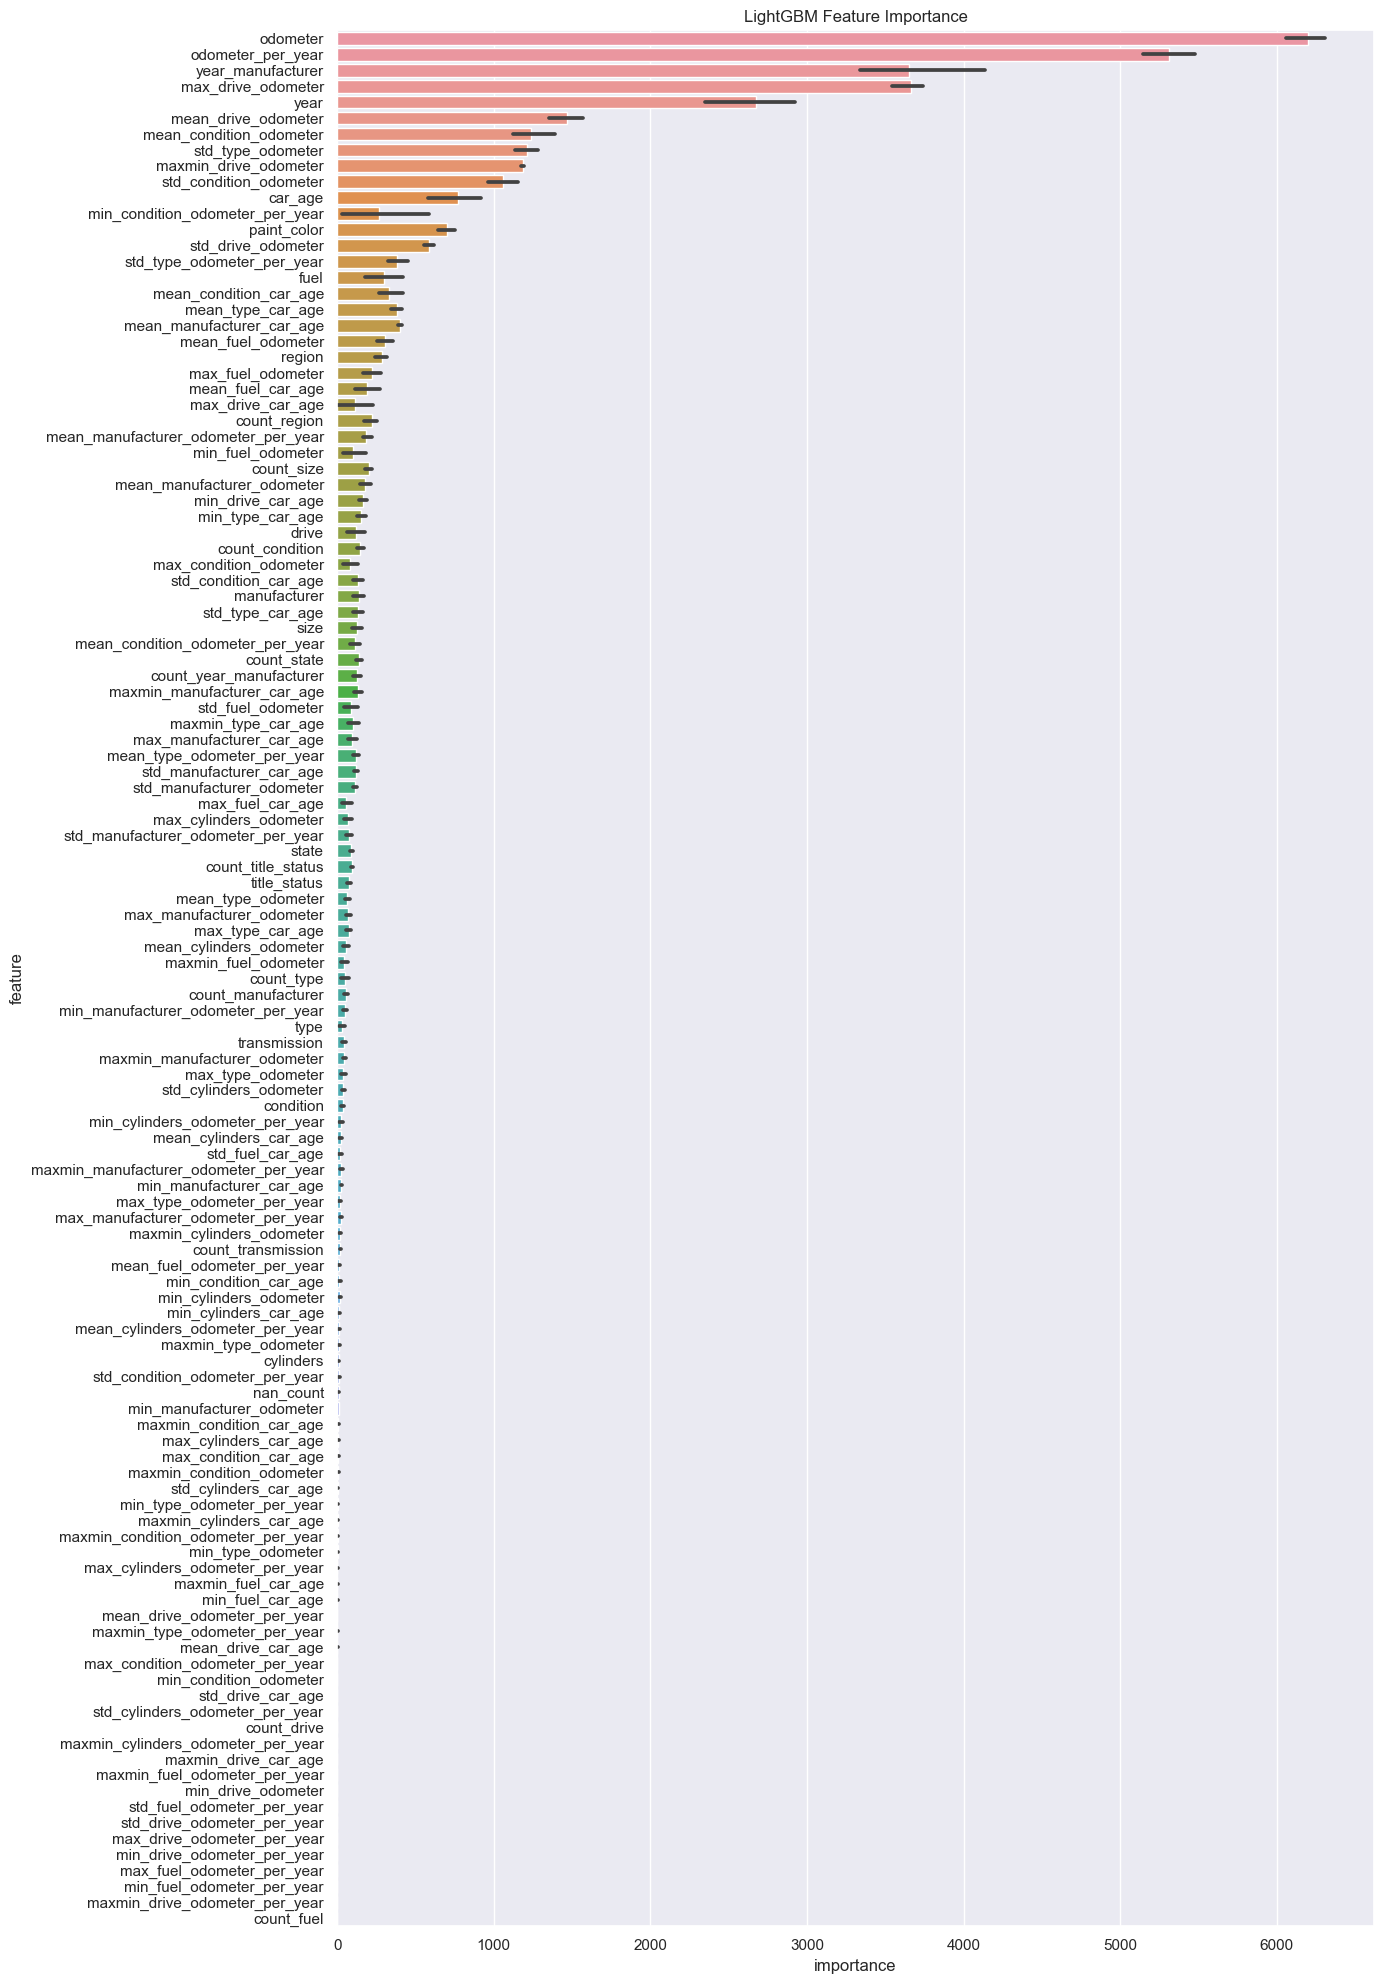

In [86]:
# 特徴量重要度
plt.figure(figsize=(14, 20))
sns.barplot(x="importance", y="feature", data=feature_importances.sort_values(by="importance", ascending=False))
plt.title("LightGBM Feature Importance")
plt.tight_layout()

In [87]:
test['price'] = np.expm1(preds)

In [88]:
test[['id','price']].to_csv('submission_without_pp.csv',index=False)

In [89]:
train_pp = pd.read_csv('../Input/train.csv')
test_pp = pd.read_csv('../Input/test.csv')
len(test_pp)

27537

In [90]:
# 同じ車両か判断するために用いる列 
# (vinだけで一意になると思ったが正しくない値が入っているケースもあるため、列を増やした)
cols = ['year', 'manufacturer','fuel', 'title_status', 'transmission']

train_pp = train_pp.groupby(cols)['price'].mean().reset_index()
test_pp = test_pp.merge(train_pp, on=cols, how='inner')
test_pp = test_pp[['id','price']]
test_pp.columns = ['id', 'price2']
len(test_pp)

22705

In [91]:
test = test.merge(test_pp, on='id', how='left')
test.loc[~test['price2'].isnull(), 'price'] = test.loc[~test['price2'].isnull(), 'price2']

In [92]:
test[['id','price']].to_csv('submission.csv',index=False,header=False)

In [93]:
test[['id','price']]

,id,price
0,27532,21233.509615
1,27533,6811.375000
2,27534,7389.870968
3,27535,25217.833333
4,27536,7586.208839
...,...,...
27532,55064,27914.000000
27533,55065,12016.600000
27534,55066,7785.521739
27535,55067,10558.846154
